In [1]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, learning_curve
import sklearn.metrics

%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

In [2]:
path = '../datas/nlp_results/'
voting_df = pd.read_csv(path+'voting_with_topics.csv')
print('Entries in the DataFrame',voting_df.shape)

#Dropping the useless column
voting_df = voting_df.drop('Unnamed: 0',1)

#Putting numerical values into the columns that should have numerical values
#print(voting_df.columns.values)

num_cols = ['Decision', ' armée', ' asile / immigration', ' assurances', ' budget', ' dunno', ' entreprise/ finance',
           ' environnement', ' famille / enfants', ' imposition', ' politique internationale', ' retraite  ']
voting_df[num_cols] = voting_df[num_cols].apply(pd.to_numeric)

#Inserting the full name at the second position
voting_df.insert(2,'Name', voting_df['FirstName'] + ' ' + voting_df['LastName'])

voting_df.head(3)

Entries in the DataFrame (1713854, 39)


,BillTitle,BusinessNumber,Name,BusinessShortNumber,BusinessTitle,Canton,CantonID,CantonName,Decision,DecisionText,FirstName,ID,IdLegislativePeriod,IdSession,IdVote,Language,LastName,MeaningNo,MeaningYes,ParlGroupCode,ParlGroupColour,ParlGroupName,ParlGroupNameAbbreviation,PersonNumber,RegistrationNumber,Subject,VoteEnd,text,armée,asile / immigration,assurances,budget,dunno,entreprise/ finance,environnement,famille / enfants,imposition,politique internationale,retraite
0,Arrêté fédéral concernant la contribution de l...,20090055,Chiara Simoneschi-Cortesi,9.055,Réduction des disparités économiques et social...,TI,21,Tessin,7,Die Präsidentin/der Präsident stimmt nicht,Chiara,1183799,48,4811,6392,FR,Simoneschi-Cortesi,Proposition de la minorité Stamm (ne pas entre...,Proposition de la majorité (entrer en matière),CEg,#FFFFA500,Groupe conservateur-catholique,Groupe K,511,2652,Entrer en matière,2009-09-07T15:44:26.69,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
1,Arrêté fédéral concernant la contribution de l...,20090055,Pascale Bruderer Wyss,9.055,Réduction des disparités économiques et social...,AG,1,Aargau,5,Hat nicht teilgenommen,Pascale,1183800,48,4811,6392,FR,Bruderer Wyss,Proposition de la minorité Stamm (ne pas entre...,Proposition de la majorité (entrer en matière),S,#FFFF0000,Groupe socialiste,Groupe S,823,2652,Entrer en matière,2009-09-07T15:44:26.69,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
2,Arrêté fédéral concernant la contribution de l...,20090055,Guy Parmelin,9.055,Réduction des disparités économiques et social...,VD,23,Waadt,5,Hat nicht teilgenommen,Guy,1183801,48,4811,6392,FR,Parmelin,Proposition de la minorité Stamm (ne pas entre...,Proposition de la majorité (entrer en matière),V,#FF006400,"Groupe des Paysans, Artisans et Bourgeois",Groupe B,1108,2652,Entrer en matière,2009-09-07T15:44:26.69,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993


# Evolution of topics in the votes

We take a look at the data in order to observe which topics are most talked about in the votes, and see whether or not it changes over the years.

In [63]:
voting_df_copy = voting_df
voting_df_copy.head(3)

,BillTitle,BusinessNumber,Name,BusinessShortNumber,BusinessTitle,Canton,CantonID,CantonName,Decision,DecisionText,FirstName,ID,IdLegislativePeriod,IdSession,IdVote,Language,LastName,MeaningNo,MeaningYes,ParlGroupCode,ParlGroupColour,ParlGroupName,ParlGroupNameAbbreviation,PersonNumber,RegistrationNumber,Subject,VoteEnd,text,armée,asile / immigration,assurances,budget,dunno,entreprise/ finance,environnement,famille / enfants,imposition,politique internationale,retraite
0,Arrêté fédéral concernant la contribution de l...,20090055,Chiara Simoneschi-Cortesi,9.055,Réduction des disparités économiques et social...,TI,21,Tessin,7,Die Präsidentin/der Präsident stimmt nicht,Chiara,1183799,48,4811,6392,FR,Simoneschi-Cortesi,Proposition de la minorité Stamm (ne pas entre...,Proposition de la majorité (entrer en matière),CEg,#FFFFA500,Groupe conservateur-catholique,Groupe K,511,2652,Entrer en matière,2009-09-07T15:44:26.69,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
1,Arrêté fédéral concernant la contribution de l...,20090055,Pascale Bruderer Wyss,9.055,Réduction des disparités économiques et social...,AG,1,Aargau,5,Hat nicht teilgenommen,Pascale,1183800,48,4811,6392,FR,Bruderer Wyss,Proposition de la minorité Stamm (ne pas entre...,Proposition de la majorité (entrer en matière),S,#FFFF0000,Groupe socialiste,Groupe S,823,2652,Entrer en matière,2009-09-07T15:44:26.69,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
2,Arrêté fédéral concernant la contribution de l...,20090055,Guy Parmelin,9.055,Réduction des disparités économiques et social...,VD,23,Waadt,5,Hat nicht teilgenommen,Guy,1183801,48,4811,6392,FR,Parmelin,Proposition de la minorité Stamm (ne pas entre...,Proposition de la majorité (entrer en matière),V,#FF006400,"Groupe des Paysans, Artisans et Bourgeois",Groupe B,1108,2652,Entrer en matière,2009-09-07T15:44:26.69,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993


In [ ]:
voting_df_copy['VoteEnd'] = [x[:4] for x in voting_df_copy['VoteEnd']]
voting_df_copy.head(3)
dates = voting_df_copy['VoteEnd'].drop_duplicates()
dates = np.sort(dates)
dates

In [ ]:
#voting_df_copy.index = voting_df_copy['VoteEnd']
voting_df_copy = voting_df_copy.set_index(['VoteEnd', 'Name'])

voting_df_copy.head(3)

In [ ]:
voting_df_copy.columns

In [ ]:
#voting_df_copy.loc['2009-09'][' armée']
#topicArmee = np.mean(voting_df_copy.loc['2009-09'][' armée'])

#print(topicArmee)
#indices = voting_df_copy.index[:].values
#indices

topics = ['armée', 'asile / immigration', 'assurances', 'budget', 'dunno', 'entreprise/ finance', 'environnement', 'famille / enfants', 'imposition', 'politique internationale', 'retraite  ']
topicEvolution = pd.DataFrame(index = dates, columns = topics)
#topicArmeeEvolution = []

for topic in topics:
    for date in dates:
        topicEvolution.loc[date][topic] = np.mean(voting_df_copy.loc[date][' '+topic])
        #topicArmeeEvolution.append(np.mean(voting_df_copy.loc[date][' '+topic]))
    #topicEvolution[topic].plot
    plt.plot(dates,topicEvolution[topic])

plt.legend(topics)
topicEvolution

In [ ]:
topicEvolution.to_json("topicEvolution.json")

# Extract vote decision for each subject

We exctract here for each voted subject the final result of the votation, by comparing the number of *Yes* to the number of *No*.

In [3]:
voting_df = pd.read_csv(path+'voting_with_topics_sentiment.csv')
voting_df_Decision = voting_df
#voting_df_TopicAcceptation = voting_df_TopicAcceptation.set_index(['IdVote', 'Name'])
voting_df_Decision.head(3)

,BillTitle,BusinessTitle,FirstName,LastName,Decision,ParlGroupCode,text,armée,asile / immigration,assurances,budget,dunno,entreprise/ finance,environnement,famille / enfants,imposition,politique internationale,retraite,text_eng,positive,negative,neutral,compound
0,Arrêté fédéral concernant la contribution de l...,Réduction des disparités économiques et social...,Chiara,Simoneschi-Cortesi,7,0,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993,Federal decree on Switzerland's contribution i...,0.075,0.0,0.925,0.4404
1,Arrêté fédéral concernant la contribution de l...,Réduction des disparités économiques et social...,Pascale,Bruderer Wyss,5,1,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993,Federal decree on Switzerland's contribution i...,0.075,0.0,0.925,0.4404
2,Arrêté fédéral concernant la contribution de l...,Réduction des disparités économiques et social...,Guy,Parmelin,5,2,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993,Federal decree on Switzerland's contribution i...,0.075,0.0,0.925,0.4404


In [4]:
texts = voting_df_Decision['text'].unique()
print(len(texts))
texts[0]

3470


"Arrêté fédéral concernant la contribution de la Suisse en faveur de la Bulgarie et de la Roumanie au titre de la réduction des disparités économiques et sociales dans l'Union européenne élargie Réduction des disparités économiques et sociales dans l'UE. Contribution de la Suisse en faveur de la Roumanie et de la Bulgarie"

In [5]:
voting_df_Decision = voting_df_Decision.set_index(['text', 'LastName'])
voting_df_Decision.head()

BillTitle  \
text                                               LastName                                                                
Arrêté fédéral concernant la contribution de la... Simoneschi-Cortesi  Arrêté fédéral concernant la contribution de l...   
                                                   Bruderer Wyss       Arrêté fédéral concernant la contribution de l...   
                                                   Parmelin            Arrêté fédéral concernant la contribution de l...   
                                                   Germanier           Arrêté fédéral concernant la contribution de l...   
                                                   Engelberger         Arrêté fédéral concernant la contribution de l...   

                                                                                                           BusinessTitle  \
text                                               LastName                                                                
Arrêté fédéral concernant la contribution de la... Simoneschi-Cortesi  Réduction des disparités économiques et social...   
                                                   Bruderer Wyss       Réduction des disparités économiques et social...   
                                                   Parmelin            Réduction des disparités économiques et social...   
                                                   Germanier           Réduction des disparités économiques et social...   
                                                   Engelberger         Réduction des disparités économiques et social...   

                                                                       FirstName  \
text                                               LastName                        
Arrêté fédéral concernant la contribution de la... Simoneschi-Cortesi     Chiara   
                                                   Bruderer Wyss         Pascale   
                                                   Parmelin                  Guy   
                                                   Germanier           Jean-René   
                                                   Engelberger               Edi   

                                                                       Decision  \
text                                               LastName                       
Arrêté fédéral concernant la contribution de la... Simoneschi-Cortesi         7   
                                                   Bruderer Wyss              5   
                                                   Parmelin                   5   
                                                   Germanier                  5   
                                                   Engelberger                5   

                                                                       ParlGroupCode  \
text                                               LastName                            
Arrêté fédéral concernant la contribution de la... Simoneschi-Cortesi              0   
                                                   Bruderer Wyss                   1   
                                                   Parmelin                        2   
                                                   Germanier                       3   
                                                   Engelberger                     3   

                                                                          armée  \
text                                               LastName                       
Arrêté fédéral concernant la contribution de la... Simoneschi-Cortesi  0.006995   
                                                   Bruderer Wyss       0.006995   
                                                   Parmelin            0.006995   
                                                   Germanier           0.006995   
                                                   Engelberger         0.006995   

   

In [6]:
decisions_dict = {}
decisions_dict[texts[0]] = np.sum(voting_df_Decision.loc[texts[0]].Decision == 1) > np.sum(voting_df_Decision.loc[texts[0]].Decision == 2)
for t in texts:
    decisions_dict[t] = np.sum(voting_df_Decision.loc[t].Decision == 1) > np.sum(voting_df_Decision.loc[t].Decision == 2)

In [7]:
len(decisions_dict)

3470

In [44]:
decisions_df = pd.DataFrame.from_dict(decisions_dict, 'index')
decisions_df.columns = ['Decision']
decisions_df.head()

,Decision
"Loi fédérale sur l'aménagement du territoire (Loi sur l'aménagement du territoire, LAT) Loi sur l'aménagement du territoire. Révision partielle",True
Pour des assurés égaux devant la perte de gain en cas de maladie,False
Publication des dons faits aux acteurs politiques par les entreprises et institutions du secteur public,False
Responsabilité civile. Uniformiser la réglementation et modifier quelques points,False
Harmonisation dans le domaine des subsides à la formation,True


# Ratio of acceptation for each topic

We now want to see if there is a significant correlation between a vote being accepted and the topic of the vote.

In [61]:
path = '../datas/nlp_results/'
voting_df = pd.read_csv(path+'voting_with_topics_unique_sentiment.csv')
voting_df_TopicAcceptation = voting_df
#voting_df_TopicAcceptation = voting_df_TopicAcceptation.set_index(['IdVote', 'Name'])
voting_df_TopicAcceptation.head(3)

,armée,asile / immigration,assurances,budget,dunno,entreprise/ finance,environnement,famille / enfants,imposition,politique internationale,retraite,text,text_eng,positive,negative,neutral,compound
0,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993,Arrêté fédéral concernant la contribution de l...,Federal decree on Switzerland's contribution i...,0.075,0.000,0.925,0.4404
1,0.018182,0.018185,0.018183,0.271557,0.564795,0.018183,0.018182,0.018183,0.018183,0.018183,0.018184,Renforcement du Traité sur la non-proliférati...,Strengthening of the Treaty on the non-prolif...,0.227,0.206,0.567,0.0772
2,0.015152,0.389858,0.015152,0.232520,0.256405,0.015152,0.015152,0.015152,0.015152,0.015154,0.015152,Une zone exempte d'armes nucléaires au coeur ...,A nuclear weapon free zone in the heart of Eu...,0.264,0.176,0.560,0.2732


In [62]:
voting_df_TopicAcceptation['Accepted'] = decisions_df.loc[voting_df_TopicAcceptation['text']].Decision.values
voting_df_TopicAcceptation.head(3)

,armée,asile / immigration,assurances,budget,dunno,entreprise/ finance,environnement,famille / enfants,imposition,politique internationale,retraite,text,text_eng,positive,negative,neutral,compound,Accepted
0,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993,Arrêté fédéral concernant la contribution de l...,Federal decree on Switzerland's contribution i...,0.075,0.000,0.925,0.4404,True
1,0.018182,0.018185,0.018183,0.271557,0.564795,0.018183,0.018182,0.018183,0.018183,0.018183,0.018184,Renforcement du Traité sur la non-proliférati...,Strengthening of the Treaty on the non-prolif...,0.227,0.206,0.567,0.0772,False
2,0.015152,0.389858,0.015152,0.232520,0.256405,0.015152,0.015152,0.015152,0.015152,0.015154,0.015152,Une zone exempte d'armes nucléaires au coeur ...,A nuclear weapon free zone in the heart of Eu...,0.264,0.176,0.560,0.2732,False


In [63]:
topics = [' armée', ' asile / immigration', ' assurances', ' budget', ' dunno', ' entreprise/ finance', ' environnement', ' famille / enfants', ' imposition', ' politique internationale', ' retraite  ']

voting_df_TopicAcceptation['Topic'] = voting_df_TopicAcceptation[topics].idxmax(axis=1)

voting_df_TopicAcceptation.head(3)

,armée,asile / immigration,assurances,budget,dunno,entreprise/ finance,environnement,famille / enfants,imposition,politique internationale,retraite,text,text_eng,positive,negative,neutral,compound,Accepted,Topic
0,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993,Arrêté fédéral concernant la contribution de l...,Federal decree on Switzerland's contribution i...,0.075,0.000,0.925,0.4404,True,asile / immigration
1,0.018182,0.018185,0.018183,0.271557,0.564795,0.018183,0.018182,0.018183,0.018183,0.018183,0.018184,Renforcement du Traité sur la non-proliférati...,Strengthening of the Treaty on the non-prolif...,0.227,0.206,0.567,0.0772,False,dunno
2,0.015152,0.389858,0.015152,0.232520,0.256405,0.015152,0.015152,0.015152,0.015152,0.015154,0.015152,Une zone exempte d'armes nucléaires au coeur ...,A nuclear weapon free zone in the heart of Eu...,0.264,0.176,0.560,0.2732,False,asile / immigration


In [74]:
meanAcceptation = np.mean(voting_df_TopicAcceptation.loc[:, 'Accepted'])
print('Precentage of acceptation of a votation : ', meanAcceptation)

Precentage of acceptation of a votation :  0.655331412104


In [66]:
voting_df_TopicAcceptation = voting_df_TopicAcceptation[['Topic', 'Accepted']]
voting_df_MeanAcceptation = voting_df_TopicAcceptation.groupby(by='Topic', axis=0).mean()
voting_df_MeanAcceptation

,Accepted
Topic,
armée,0.589862
asile / immigration,0.749465
assurances,0.548117
budget,0.620469
dunno,0.601942
entreprise/ finance,0.742991
environnement,0.520661
famille / enfants,0.657658
imposition,0.720833


We observe **qualitatively** that votations about *army*, *assurances* and *environnement* are less accepted than the votations about other topics in general. Conversly, votations about *asile / immigration*, *enterprise / finance* and *imposition* are more likely to be accepted. This analysis is performed based on a quick look to the data. The aim of the next part is to determine whether or not these observed variatiations are statistically significant.

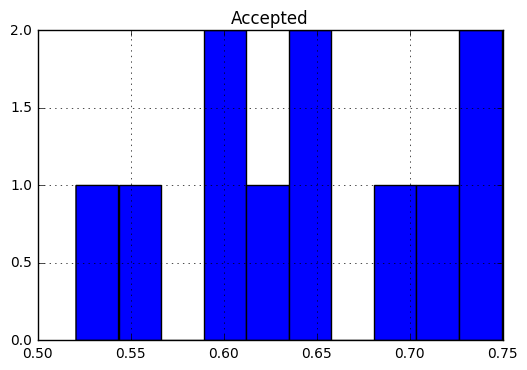

In [73]:
#voting_df_MeanAcceptation['Accepted'].plot.hist(by = 'Topic')
voting_df_MeanAcceptation.hist()
plt.show()

In [53]:

voting_df_TopicAcceptation = voting_df_TopicAcceptation.set_index('Topic')
voting_df_TopicAcceptation.head(3)

,Accepted
Topic,
asile / immigration,True
dunno,False
asile / immigration,False


The aim of the statistical test that we want to use is to determine whether a sample of votations has a mean acceptation that differs from the global mean acceptation. The samples correspond here to the votations about each topic. Thus we apply one statistical test per topic, whose null hypothesis is that the sample about this topic has the same mean acceptation that the global mean, ie 65.5%. The test that we use is a One-sample T test.

In [60]:
import scipy.stats as stats

for t in topics:
    votationAboutTopic = voting_df_TopicAcceptation.loc[t]
    print('Topic ' + t,'- Number of votations',len(votationAboutTopic.loc[:, 'Accepted']))
    print(stats.ttest_1samp(a= np.array(votationAboutTopic.loc[:,'Accepted']), popmean=meanAcceptation))
    print()

Topic  armée - Number of votations 434
Ttest_1sampResult(statistic=-2.7697705019658443, pvalue=0.005850777110375586)

Topic  asile / immigration - Number of votations 467
Ttest_1sampResult(statistic=4.6894938073401846, pvalue=3.6029713344636828e-06)

Topic  assurances - Number of votations 239
Ttest_1sampResult(statistic=-3.3234671873908743, pvalue=0.0010292361514610798)

Topic  budget - Number of votations 469
Ttest_1sampResult(statistic=-1.5541597954907025, pvalue=0.12082226015411453)

Topic  dunno - Number of votations 412
Ttest_1sampResult(statistic=-2.2111976011878141, pvalue=0.027571917161008392)

Topic  entreprise/ finance - Number of votations 428
Ttest_1sampResult(statistic=4.1452002473425873, pvalue=4.0961257123752814e-05)

Topic  environnement - Number of votations 121
Ttest_1sampResult(statistic=-2.9529997116064282, pvalue=0.003787200428245817)

Topic  famille / enfants - Number of votations 333
Ttest_1sampResult(statistic=0.089329385887242763, pvalue=0.92887400382922802)



We consider a tolerance threshold for the p-value of 5%. Thus we can reject the null hypothesis for several topics :
- armée : the acceptation mean is lower than the global mean
- asile / immigration : the acceptation mean is higher than the global mean
- assurances : the acceptation mean is lower than the global mean
- entreprise/ finance : the acceptation mean is higher than the global mean
- environnement : the acceptation mean is lower than the global mean
- imposition : the acceptation mean is higher than the global mean